In [1]:
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession

from bs4 import BeautifulSoup
import re
import time

C:\Users\katma\anaconda3\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [2]:
def get_source(url):
    """Return the source code for the provided URL. 
    Args: 
        url (string): URL of the page to scrape.
    Returns:
        response (object): HTTP response object from requests_html. 
    """
    time.sleep(5) # prevents captcha hopefully

    try:
        session = HTMLSession()
        response = session.get(url)
        return response

    except requests.exceptions.RequestException as e:
        print(e)

In [3]:
def get_author_profile(author_name):
    
    # get HTML response for author
    author_name = author_name.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ß", "ss")
    query = author_name.replace(" ", "-")
    response = get_source("https://www.researchgate.net/profile/" + query)
    soup = BeautifulSoup(response.html.raw_html)
        
    return soup

In [4]:
def get_author_publication_list(author_name, page):
    
    # get HTML response for author
    author_name = author_name.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ß", "ss")
    query = author_name.replace(" ", "+")
    response = get_source(f"https://www.researchgate.net/search/publication?q=\"{query}\"&page={page}")
    soup = BeautifulSoup(response.html.raw_html)
    
    return soup

In [5]:
def get_all_publications(page):
    return page.find_all("div", class_="nova-legacy-v-publication-item__body")

In [6]:
def get_publisher(publication_link, publication_type):
    
    publication_profile = BeautifulSoup(get_source(publication_link).html.raw_html)
    
    metadata = publication_profile.find("div", class_="research-detail-header-section__metadata")

    publisher = None
    
    if not metadata: # don't search for publisher if no metadata
        pass
    
    elif publication_type == 'Article':

        if metadata.find("a", class_="nova-legacy-e-link nova-legacy-e-link--color-inherit nova-legacy-e-link--theme-decorated"):
            publisher = metadata.find("a", class_="nova-legacy-e-link nova-legacy-e-link--color-inherit nova-legacy-e-link--theme-decorated").text

    elif publication_type in ['Book', 'Chapter']:

        if metadata.find("li", class_="nova-legacy-e-list__item"):

            # there are multiple items with that class
            for meta in metadata.find_all("li", class_="nova-legacy-e-list__item"):
                if "Publisher" in meta.text:
                    publisher = meta.text.split("Publisher: ",1)[1]

    elif publication_type in ['Poster', 'Conference Paper']:

        if metadata.find("li", class_="nova-legacy-e-list__item"):

            # there are multiple items with that class
            for meta in metadata.find_all("li", class_="nova-legacy-e-list__item"):
                if "Conference" in meta.text:
                    publisher = meta.text.split("Conference: ",1)[1]
                    
    return publisher

In [12]:
def get_publication_info(publication):
    
    publication_title = ""
    publication_year = ""
    authors_list = []
    publication_type = ""
    publisher = ""
    
    # publication title
    if publication.find("div", class_="nova-legacy-e-text nova-legacy-e-text--size-l nova-legacy-e-text--family-sans-serif nova-legacy-e-text--spacing-none nova-legacy-e-text--color-inherit nova-legacy-v-publication-item__title"):
        publication_title = publication.find("div", class_="nova-legacy-e-text nova-legacy-e-text--size-l nova-legacy-e-text--family-sans-serif nova-legacy-e-text--spacing-none nova-legacy-e-text--color-inherit nova-legacy-v-publication-item__title").string

    # publication year
    if publication.find("li", class_="nova-legacy-e-list__item nova-legacy-v-publication-item__meta-data-item"):
        publication_year_string = publication.find("li", class_="nova-legacy-e-list__item nova-legacy-v-publication-item__meta-data-item").string
        publication_year = re.search(r"([0-9]{4})", publication_year_string).group(1) # only get year
    
    # authors
    if publication.find("span", class_="nova-legacy-v-person-inline-item__fullname"):
        publication_author_list = publication.find_all("span", class_="nova-legacy-v-person-inline-item__fullname")
        authors_list = [x.text for x in publication_author_list]
    
    # publication type
    if publication.find("span", class_= "nova-legacy-e-badge nova-legacy-e-badge--color-green nova-legacy-e-badge--display-block nova-legacy-e-badge--luminosity-high nova-legacy-e-badge--size-l nova-legacy-e-badge--theme-solid nova-legacy-e-badge--radius-m nova-legacy-v-publication-item__badge"):
        publication_type = publication.find("span", class_= "nova-legacy-e-badge nova-legacy-e-badge--color-green nova-legacy-e-badge--display-block nova-legacy-e-badge--luminosity-high nova-legacy-e-badge--size-l nova-legacy-e-badge--theme-solid nova-legacy-e-badge--radius-m nova-legacy-v-publication-item__badge").text
    
    # publisher
    if publication.find("div", class_="nova-legacy-e-text nova-legacy-e-text--size-l nova-legacy-e-text--family-sans-serif nova-legacy-e-text--spacing-none nova-legacy-e-text--color-inherit nova-legacy-v-publication-item__title")\
    .find("a", class_="nova-legacy-e-link nova-legacy-e-link--color-inherit nova-legacy-e-link--theme-bare"):

        publication_link = publication.find("div", class_="nova-legacy-e-text nova-legacy-e-text--size-l nova-legacy-e-text--family-sans-serif nova-legacy-e-text--spacing-none nova-legacy-e-text--color-inherit nova-legacy-v-publication-item__title")\
        .find("a", class_="nova-legacy-e-link nova-legacy-e-link--color-inherit nova-legacy-e-link--theme-bare")['href']
        
        if not publication_link.startswith("https://www.researchgate.net/"):
            publication_link = "https://www.researchgate.net/" + publication_link
        
        publisher = get_publisher(publication_link, publication_type)
    
    return publication_title, publication_year, authors_list, publication_type, publisher

In [8]:
def get_dataframe_with_publications(author_name):
    author_profile = get_author_profile(author_name)
    
    publication_titles = []
    publication_years = []
    authors_lists = []
    publication_types = []
    publisher_list = []
    author_name_list = []

    
    if author_profile:
        all_publication_entries = get_all_publications(author_profile)
        
    for publication_entry in all_publication_entries:
        publication_title, publication_year, authors_list, publication_type, publisher = get_publication_info(publication_entry)

        publication_titles.append(publication_title)
        publication_years.append(publication_year)
        authors_lists.append(authors_list)
        publication_types.append(publication_type)
        author_name_list.append(author_name)
        publisher_list.append(publisher)
    
    
    data = {'PUB_TITLE': publication_titles, 
            'PUB_YEAR': publication_years, 
            'PUB_AUTHORS': authors_lists,  
            'PUB_TYPE': publication_types,
            'PUB_PUBLISHER': publisher_list,
            'AUTHOR_NAME': author_name_list}
    
    return pd.DataFrame(data)

In [9]:
def get_dataframe_with_publications_no_profile(author_name):
    
    publication_titles = []
    publication_years = []
    authors_lists = []
    publication_types = []
    publisher_list = []
    author_name_list = []
    
    keep_going = True
    page_number = 1
    
    while keep_going:
        page_with_publications = get_author_publication_list(author_name, page_number)
        page_number = page_number + 1 # go to next page
        
        all_publication_entries = get_all_publications(page_with_publications)
        
        if not all_publication_entries:
            keep_going = False
            continue
        
        for publication_entry in all_publication_entries:
            publication_title, publication_year, authors_list, publication_type, publisher = get_publication_info(publication_entry)
        
            publication_titles.append(publication_title)
            publication_years.append(publication_year)
            authors_lists.append(authors_list)
            publication_types.append(publication_type)
            author_name_list.append(author_name)
            publisher_list.append(publisher)
    
    
    data = {'PUB_TITLE': publication_titles, 
            'PUB_YEAR': publication_years, 
            'PUB_AUTHORS': authors_lists,  
            'PUB_TYPE': publication_types,
            'PUB_PUBLISHER': publisher_list,
            'AUTHOR_NAME': author_name_list}
    
    return pd.DataFrame(data)

In [21]:
# get HTML response for author
author_name = "Gerhard Hellstern"

pd_publications = get_dataframe_with_publications(author_name)
if pd_publications.empty:
    pd_publications = get_dataframe_with_publications_no_profile(author_name)

<html>
<head>
<script nonce="4eef5W0WkYtNFhQfZ24O5kXm1o66H7JB">
        eval(function(p,a,c,k,e,d){e=function(c){return c};if(!''.replace(/^/,String)){while(c--){d[c]=k[c]||c}k=[function(e){return d[e]}];e=function(){return'\\w+'};c=1};while(c--){if(k[c]){p=p.replace(new RegExp('\\b'+e(c)+'\\b','g'),k[c])}}return p}('(11(){7 38=11(36,31){27(7 5=0;5<36.20;5++){27(7 8=0;8<31.20;8++){9(36[5+8]!==31[8]){51;}9(8===31.20-1){12 5;}}}12-1;};7 37;54{57[0]();}61(18){37=18;}9(38(37.52,\'53\')>-1){12;}9(10.58||10.70||10.60||10.62||10.65||10.66||10.67){12;}7 48=(11(){7 23="68+/=";12 11(13){7 26="";7 32,21,25,35,34,30,24;7 5=0;13=59(42(13));55(5<13.20){32=13.29(5++);21=13.29(5++);25=13.29(5++);35=32>>2;34=((32&3)<<4)|(21>>4);30=((21&15)<<2)|(25>>6);24=25&63;9(46(21)){30=24=64;}40 9(46(25)){24=64;}26=26+23.28(35)+23.28(34)+23.28(30)+23.28(24);}12 26;}})(),45=11(33){7 18="";27(7 5=0;5<33.20;5++){18=18+56.49(33.29(5)^50);}12 18;};(11(14){7 17=69 47();17.72=11(){9(17.76==47.93){9(17.94==71){10.96.97(14.
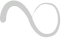

In [26]:
get_author_publication_list(author_name, 1)